<a href="https://colab.research.google.com/github/ShinjiKatoA16/UCSY-sw-eng/blob/master/iristest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# import libraries and read iris dataset

import numpy as np
import pandas as pd
# import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance

# following 2 lines for normalization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns = ['sepal_len', 'sepal_width', 'petal_len', 'petal_width'])
target = pd.DataFrame(iris.target, columns = ['target'])

clf = RandomForestClassifier(n_estimators=100, random_state=1)
#clf = LogisticRegression()
# clf = XGBClassifier()

In [40]:
# Function to add new features
# please add some features, for example ratio of sepal length/width, differnce between petal length/width, estimated size of petal(petal length x width x constant?) etc

def add_feature(df):

    
    df['petal_ratio'] = df.petal_len / df.petal_width
    df['sepal_ratio'] = df.sepal_len / df.sepal_width
    df['psl_ratio'] = df.petal_len / df.sepal_len
    df['psw_ratio'] = df.petal_width / df.sepal_width
    # df['sepal_size'] = df.sepal_len * df.sepal_width
    # df['petal_size'] = df.petal_len * df.petal_width
    df['pss_ratio'] = (df.sepal_len * df.sepal_width) / (df.petal_len * df.petal_width)
    return

def add_stat_feature(df, df_maen, df_std):
    from scipy.stats import norm  # Starndard Normal distribution
    
    for col in df.columns:
        for target in df_mean.columns:
            df_scale = df_std.at[col, target]
            if df_scale == 0:   # Sanity check to avoid 0 devide
                print('unexpected condition: std=0', col, target)
            #col_val = abs(df[col]-df_mean.at[col, target])  # pandas Series (array-like 1d object)
            #df[col+'_'+str(target)] = norm.sf(col_val, loc=0, scale=df_scale) * 2  # SF for both side of SF
            df[col+'_'+str(target)] = norm.pdf((df[col]-df_mean.at[col, target])/df_scale, loc=0, scale=1)
            
    for target in ['_0', '_1', '_2']:
        proba = 'proba' + target
        df[proba] = 1.0
        for col in df.columns:
            if col[-2:] == target:
                df[proba] *= df[col]
                
    return

In [41]:
# call add_feature and Concat data and target for analysis

add_feature(df)
df_Xy = pd.concat([df, target], axis=1)
df_mean = df_Xy.groupby('target').mean().T
df_std = df_Xy.groupby('target').std().T
add_stat_feature(df, df_mean, df_std)

In [42]:
print(df_mean, '\n\n', df_std)

target               0         1         2
sepal_len     5.006000  5.936000  6.588000
sepal_width   3.428000  2.770000  2.974000
petal_len     1.462000  4.260000  5.552000
petal_width   0.246000  1.326000  2.026000
petal_ratio   6.908000  3.242837  2.780662
sepal_ratio   1.470188  2.160402  2.230453
psl_ratio     0.292756  0.717729  0.843749
psw_ratio     0.071924  0.479675  0.683616
pss_ratio    56.925120  2.970577  1.765114 

 target               0         1         2
sepal_len     0.352490  0.516171  0.635880
sepal_width   0.379064  0.313798  0.322497
petal_len     0.173664  0.469911  0.551895
petal_width   0.105386  0.197753  0.274650
petal_ratio   2.854545  0.312456  0.407367
sepal_ratio   0.118750  0.228658  0.246992
psl_ratio     0.034796  0.053626  0.043806
psw_ratio     0.029940  0.057836  0.081252
pss_ratio    26.396744  0.478105  0.248194


In [43]:
df_Xy = pd.concat([df[['proba_0', 'proba_1', 'proba_2']], target], axis=1)
df_Xy.groupby('target').describe().T

target                    0              1             2
proba_0 count  5.000000e+01   5.000000e+01  5.000000e+01
        mean   4.750587e-09  1.827203e-184  0.000000e+00
        std    9.434036e-09   0.000000e+00  0.000000e+00
        min    5.089365e-23   0.000000e+00  0.000000e+00
        25%    1.521515e-13   0.000000e+00  0.000000e+00
        50%    2.904551e-10   0.000000e+00  0.000000e+00
        75%    3.901414e-09  1.766178e-289  0.000000e+00
        max    3.887344e-08  9.136015e-183  0.000000e+00
proba_1 count  5.000000e+01   5.000000e+01  5.000000e+01
        mean   0.000000e+00   2.646223e-09  3.000664e-14
        std    0.000000e+00   5.906233e-09  2.121712e-13
        min    0.000000e+00   8.607745e-21  1.367165e-74
        25%    0.000000e+00   2.492245e-13  6.136592e-41
        50%    0.000000e+00   1.339936e-10  1.068685e-31
        75%    0.000000e+00   1.979443e-09  6.519234e-24
        max    0.000000e+00   2.932279e-08  1.500278e-12
proba_2 count  5.000000e+01   5.000000e+01  5.000000e+01
        mean   0.000000e+00   5.914127e-13  1.789710e-09
        std    0.000000e+00   4.135485e-12  4.191454e-09
        min    0.000000e+00   1.410013e-83  7.655615e-22
        25%    0.000000e+00   6.333295e-43  2.386716e-12
        50%    0.000000e+00   5.333063e-31  5.305227e-11
        75%    0.000000e+00   2.240217e-25  8.154063e-10
        max    0.000000e+00   2.924733e-11  2.282875e-08

In [44]:
df_Xy.columns

Index(['proba_0', 'proba_1', 'proba_2', 'target'], dtype='object')

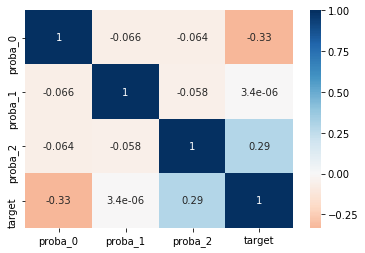

In [45]:
# Let's check correlation between features with heatmap

disp_feat = ['proba_0', 'proba_1', 'proba_2', 'target']
sns.heatmap(df_Xy[disp_feat].corr(), center=0, cmap='RdBu', annot=True)

In [46]:
# Split data into train, cross-validation


train_X, val_X, train_y, val_y = train_test_split(df, iris.target, random_state=1)

# Fit model

clf.fit(train_X, train_y)
#clf_rf = RandomForestClassifier(n_estimators=100, random_state=1).fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [47]:
# Show permutation inmportance
'''
# use xgboost.plot_importance method for xgboost
from xgboost import plot_importance
plot_importance(clf)
'''

perm = PermutationImportance(clf, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0263 ± 0.0333,psl_ratio
0 ± 0.0000,sepal_len
0 ± 0.0000,petal_width
0 ± 0.0000,petal_ratio
0 ± 0.0000,sepal_ratio
0 ± 0.0000,psw_ratio
0 ± 0.0000,pss_ratio
0 ± 0.0000,sepal_len_0
0 ± 0.0000,sepal_len_1
0 ± 0.0000,sepal_len_2


### What to do next ?

Above result was suprising.  Can we assume that

- the information of Sepal Length/Width are not necessary to predict the species of IRIS (at least for Random-Forest), how can we confirm this hypothesis
- other estimator (such as logistic-regression) will show smililar permutation importance result, how can we confirm this hypothesis
- it is not worth trying to create new features from current features. Do we have any disprrof if this hypothesis is not true in general


Please think some hypothesis from observed output, and create/modify strategy to get new finding. We have learned some tools to do that.

- Permutation Importance
- Partial Dependece Plot
- SHAP
- Probability prediction
- Data visualization tools

After finding proper combination of features, try to find best model to predict. In order to select hyper-parameters of estimator, **GridSearchCV** and **RandomizedSearchCV** will help to check the combination.
Try other estimator such as SVC, KNN, xgbost.

In [48]:
# make a prediction and show accuracy

val_p = clf.predict(val_X)
print(val_p)
print(val_y)
print((val_y == val_p).mean())
# Probality of prediction
print(clf.predict_proba(val_X))

[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]
1.0
[[0.99 0.   0.01]
 [0.12 0.77 0.11]
 [0.   0.98 0.02]
 [0.99 0.01 0.  ]
 [0.   0.37 0.63]
 [0.   0.99 0.01]
 [0.02 0.21 0.77]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.   0.98 0.02]
 [0.   0.85 0.15]
 [0.99 0.01 0.  ]
 [1.   0.   0.  ]
 [0.   0.82 0.18]
 [0.   0.82 0.18]
 [0.   0.61 0.39]
 [1.   0.   0.  ]
 [0.   0.2  0.8 ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.01 0.95 0.04]
 [0.   0.03 0.97]
 [0.   1.   0.  ]
 [0.   0.01 0.99]
 [0.   0.97 0.03]
 [0.   0.   1.  ]
 [0.01 0.09 0.9 ]
 [1.   0.   0.  ]
 [0.   0.99 0.01]
 [1.   0.   0.  ]]


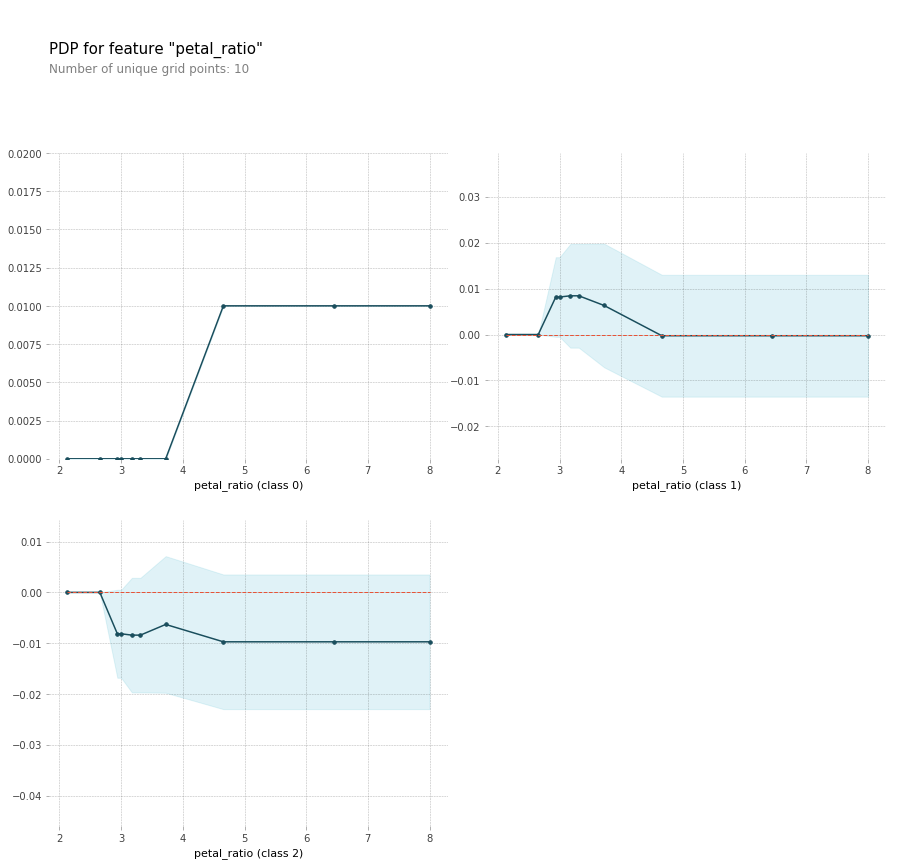

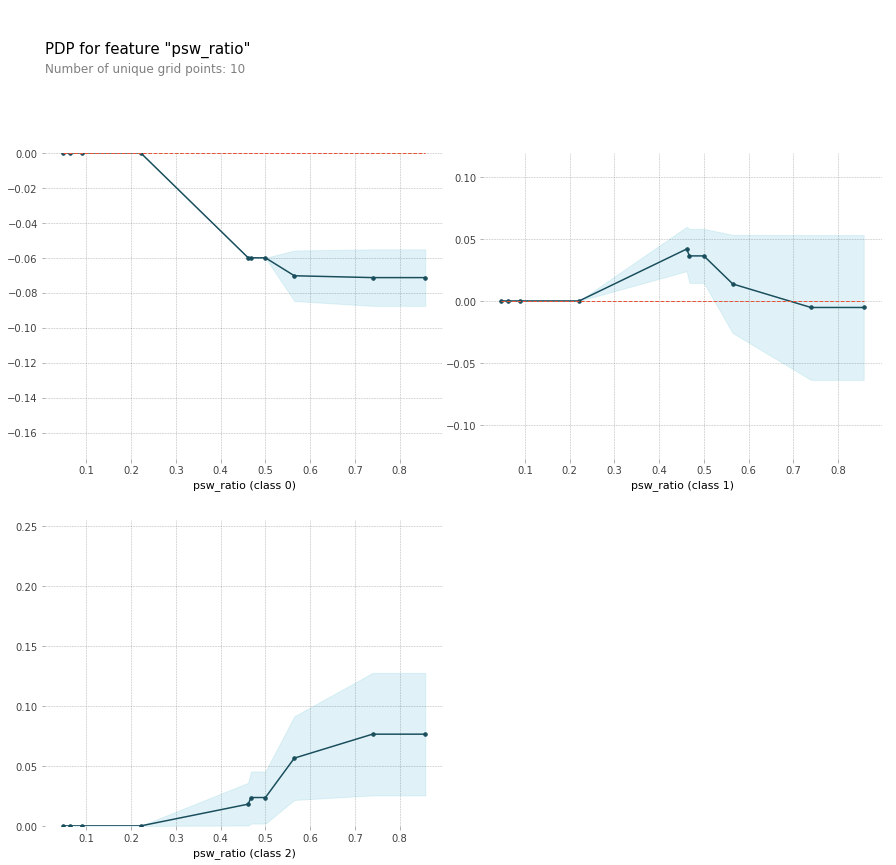

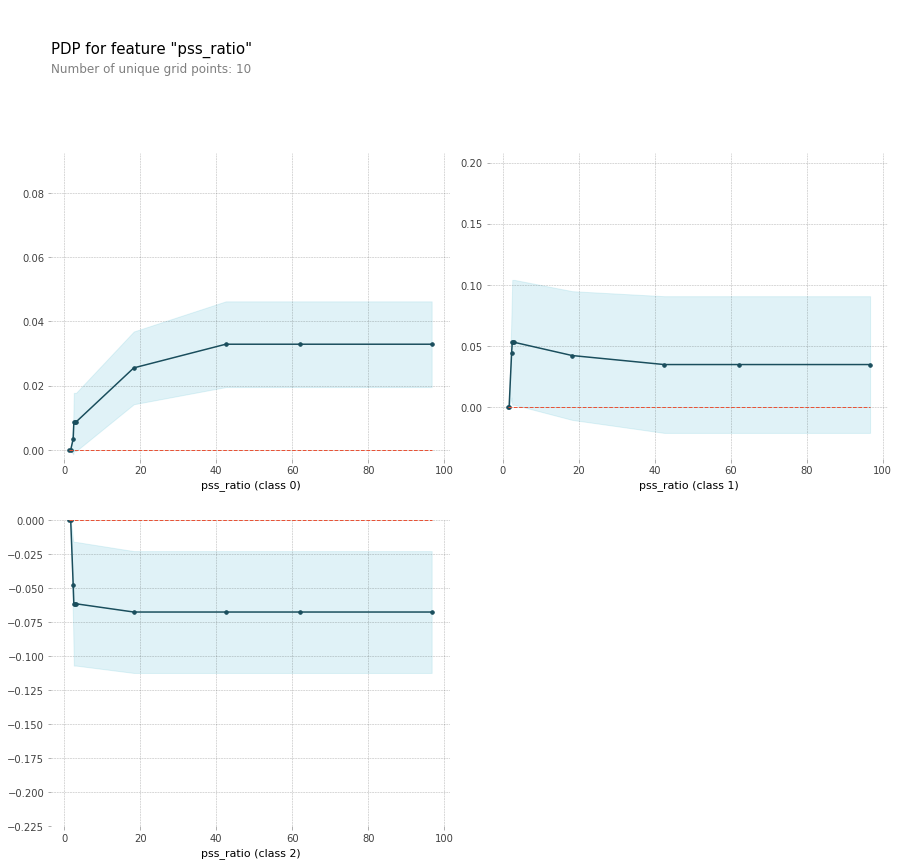

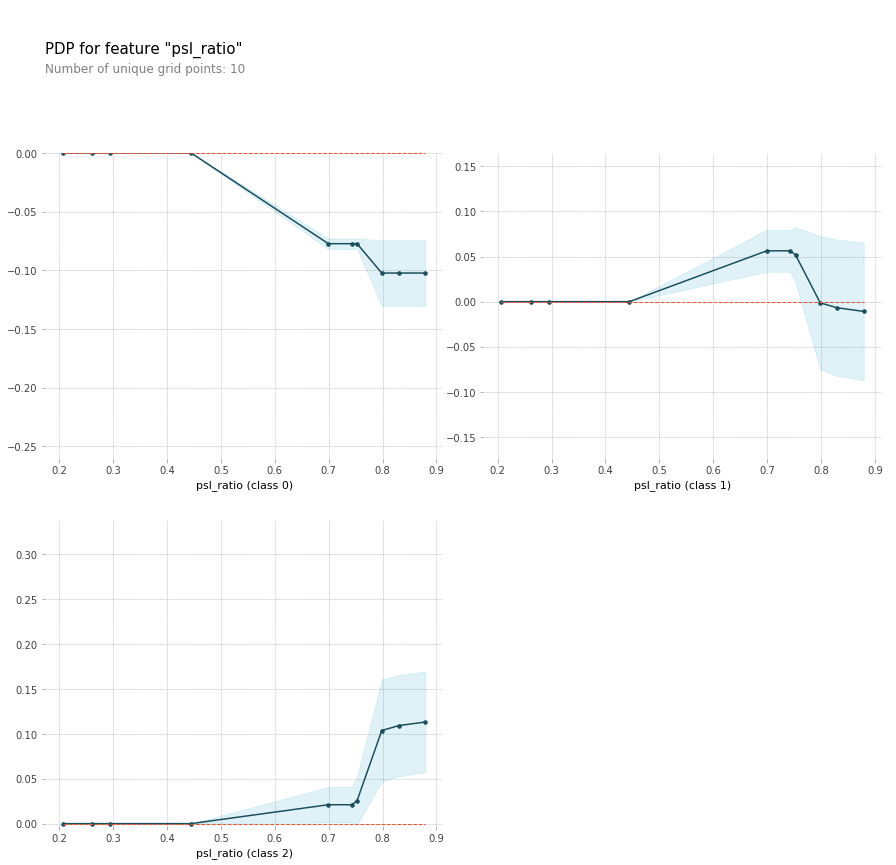

In [49]:
# PDP of petal length/width Sepal length
from pdpbox import pdp, get_dataset, info_plots

for feature_name in ['petal_ratio', 'psw_ratio', 'pss_ratio', 'psl_ratio']:
# Create the data that we will plot
    pdp_feat = pdp.pdp_isolate(model=clf, dataset=val_X, model_features=val_X.columns, feature=feature_name)

    # plot it
    pdp.pdp_plot(pdp_feat, feature_name)
    plt.show()

In [50]:
row_to_show = 22
err_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
err_prediction_array = err_prediction.values.reshape(1, -1)

print('raw data:\n', val_X.iloc[row_to_show], sep='')
clf.predict_proba(err_prediction_array)

raw data:
sepal_len        6.700000e+00
sepal_width      3.000000e+00
petal_len        5.000000e+00
petal_width      1.700000e+00
petal_ratio      2.941176e+00
sepal_ratio      2.233333e+00
psl_ratio        7.462687e-01
psw_ratio        5.666667e-01
pss_ratio        2.364706e+00
sepal_len_0      3.852207e-06
sepal_len_1      1.334098e-01
sepal_len_2      3.928018e-01
sepal_width_0    2.109008e-01
sepal_width_1    3.049675e-01
sepal_width_2    3.976479e-01
petal_len_0      2.984345e-91
petal_len_1      1.154540e-01
petal_len_2      2.419246e-01
petal_width_0    1.843530e-42
petal_width_1    6.671309e-02
petal_width_2    1.972306e-01
petal_ratio_0    1.519043e-01
petal_ratio_1    2.503279e-01
petal_ratio_2    3.691443e-01
sepal_ratio_0    4.292442e-10
sepal_ratio_1    3.791574e-01
sepal_ratio_2    3.989151e-01
psl_ratio_0      5.168836e-38
psl_ratio_1      3.462607e-01
psl_ratio_2      3.354584e-02
psw_ratio_0      2.034079e-60
psw_ratio_1      1.287219e-01
psw_ratio_2      1.415947e-01


array([[0.  , 0.61, 0.39]])

In [51]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)
# if LogsticRegession is used, use KenelExplainer
#explainer = shap.KernelExplainer(clf.predict_proba, train_X)

# Calculate Shap values
shap_values = explainer.shap_values(err_prediction)
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], err_prediction)

# SHAP force plot of class=1
shap.force_plot(explainer.expected_value[1], shap_values[1], err_prediction)


In [52]:
# SHAP forceplot of class=2
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], err_prediction)

In [53]:
val_X.columns

Index(['sepal_len', 'sepal_width', 'petal_len', 'petal_width', 'petal_ratio',
       'sepal_ratio', 'psl_ratio', 'psw_ratio', 'pss_ratio', 'sepal_len_0',
       'sepal_len_1', 'sepal_len_2', 'sepal_width_0', 'sepal_width_1',
       'sepal_width_2', 'petal_len_0', 'petal_len_1', 'petal_len_2',
       'petal_width_0', 'petal_width_1', 'petal_width_2', 'petal_ratio_0',
       'petal_ratio_1', 'petal_ratio_2', 'sepal_ratio_0', 'sepal_ratio_1',
       'sepal_ratio_2', 'psl_ratio_0', 'psl_ratio_1', 'psl_ratio_2',
       'psw_ratio_0', 'psw_ratio_1', 'psw_ratio_2', 'pss_ratio_0',
       'pss_ratio_1', 'pss_ratio_2', 'proba_0', 'proba_1', 'proba_2'],
      dtype='object')

In [54]:
# use standard scaler to adjust scaling

# val_X.columns
features = ['petal_len_0', 'petal_len_1', 'petal_len_2',
       'petal_width_0', 'petal_width_1', 'petal_width_2', 'petal_ratio_0',
       'petal_ratio_1', 'petal_ratio_2', 'psl_ratio_0', 'psl_ratio_1', 'psl_ratio_2',
       'psw_ratio_0', 'psw_ratio_1', 'psw_ratio_2', 'pss_ratio_0',
       'pss_ratio_1', 'pss_ratio_2', 'proba_0', 'proba_1', 'proba_2']
clf.fit(train_X[features], train_y)
val_p = clf.predict(val_X[features])
print(val_p)
print(val_y)
print((val_y == val_p).mean())
# Probality of prediction
print(clf.predict_proba(val_X[features]))

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)
# explainer = shap.KernelExplainer(clf.predict_proba, train_X[features])

# Calculate Shap values
err_prediction = val_X[features].iloc[row_to_show]
shap_values = explainer.shap_values(err_prediction)
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], err_prediction)

# SHAP force plot of class=1
shap.force_plot(explainer.expected_value[1], shap_values[1], err_prediction)


[0 1 1 0 1 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]
0.9736842105263158
[[0.97 0.03 0.  ]
 [0.2  0.69 0.11]
 [0.   1.   0.  ]
 [0.99 0.   0.01]
 [0.   0.51 0.49]
 [0.   0.97 0.03]
 [0.01 0.16 0.83]
 [0.92 0.03 0.05]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.83 0.17]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.87 0.13]
 [0.   0.78 0.22]
 [0.   0.66 0.34]
 [1.   0.   0.  ]
 [0.01 0.37 0.62]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.96 0.04]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]
 [0.04 0.15 0.81]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]]


### Problem

Please point out a problem in above analysis. (hint: data leakage)

### Error analysis

Predict against training data, and analyze failure data.

In [55]:
while True:
    train_X, val_X, train_y, val_y = train_test_split(df, iris.target, test_size=0.2)  # random choice
    clf.fit(train_X[features], train_y)
    val_p = clf.predict(val_X[features])
    err_count = (val_y != val_p).sum()
    print('Error Count:', err_count)
    if err_count != 0:
        break

Error Count: 2


In [56]:
print(val_p)
print(val_y)
print(np.where(val_p != val_y))
print(clf.predict_proba(val_X[features]))
err_prediction = val_X[features].iloc[1]
shap_values = explainer.shap_values(err_prediction)
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], err_prediction)

# SHAP force plot of class=1
shap.force_plot(explainer.expected_value[1], shap_values[1], err_prediction)

[1 0 2 2 2 0 1 0 0 2 1 1 1 0 0 1 1 1 2 0 0 1 2 1 0 2 1 0 0 2]
[1 0 2 2 1 0 1 0 0 2 2 1 1 0 0 1 1 1 2 0 0 1 2 1 0 2 1 0 0 2]
(array([ 4, 10]),)
[[0.   0.99 0.01]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   0.02 0.98]
 [0.   0.37 0.63]
 [0.95 0.05 0.  ]
 [0.   0.93 0.07]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.05 0.95]
 [0.04 0.69 0.27]
 [0.   0.99 0.01]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   1.   0.  ]
 [0.01 0.15 0.84]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.02 0.36 0.62]
 [0.02 0.98 0.  ]
 [0.88 0.07 0.05]
 [0.01 0.37 0.62]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.1  0.9 ]]


### Cross validation

In [57]:
from sklearn.model_selection import cross_val_score  # or ShuffleSplit

features = ['sepal_len_0',
       'sepal_len_1', 'sepal_len_2', 'sepal_width_0', 'sepal_width_1',
       'sepal_width_2', 'petal_len_0', 'petal_len_1', 'petal_len_2',
       'petal_width_0', 'petal_width_1', 'petal_width_2', 'petal_ratio_0',
       'petal_ratio_1', 'petal_ratio_2', 'sepal_ratio_0', 'sepal_ratio_1',
       'sepal_ratio_2', 'psl_ratio_0', 'psl_ratio_1', 'psl_ratio_2',
       'psw_ratio_0', 'psw_ratio_1', 'psw_ratio_2', 'pss_ratio_0',
       'pss_ratio_1', 'pss_ratio_2']
scores = cross_val_score(clf, df[features], iris.target, cv=5)
print(scores)
# std +2: confidence level 95%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[1.         0.96666667 0.9        0.93333333 1.        ]
Accuracy: 0.96 (+/- 0.08)
